# Input File

In [1]:
# === Config Cell===
# Path to cleaned dataset
DATA_PATH = "/kaggle/input/data-preprocessing-assignment/emotions_clean.csv"

# Random seed for reproducibility
RAND = 42

# Label mapping
LABEL_MAP = {0:"Sadness",1:"Joy",2:"Love",3:"Anger",4:"Fear",5:"Surprise"}

# Support Vector Machine (LinearSVC)
Support Vector Machines (SVMs) are supervised machine learning algorithms commonly used for classification tasks.  
They work by finding the optimal **hyperplane** that separates data points of different classes with the **maximum margin**.  

- **LinearSVC** is a fast and efficient implementation of a linear SVM for large datasets.  
- It uses a **linear decision boundary** (good for high-dimensional text features like TF-IDF).  
- It is well-suited for **text classification** tasks such as sentiment analysis and emotion detection.  

**Advantages:**
- Handles high-dimensional sparse data effectively.  
- Robust to overfitting in many text classification problems.  
- Computationally efficient compared to non-linear SVMs.  

**Limitations:**
- Only models linear decision boundaries.  
- Performance may drop if the dataset is highly non-linear.  

Samples: 
  train: 237389 
  val  : 50869 
  test : 50870

Validation comparison (C → Macro-F1 / Accuracy):
  C=0.5  macroF1=0.9592  acc=0.9671
  C=1.0  macroF1=0.9597  acc=0.9670
  C=2.0  macroF1=0.9593  acc=0.9665
  C=4.0  macroF1=0.9575  acc=0.9647

Best C on validation: 1.0 (macroF1=0.9597)


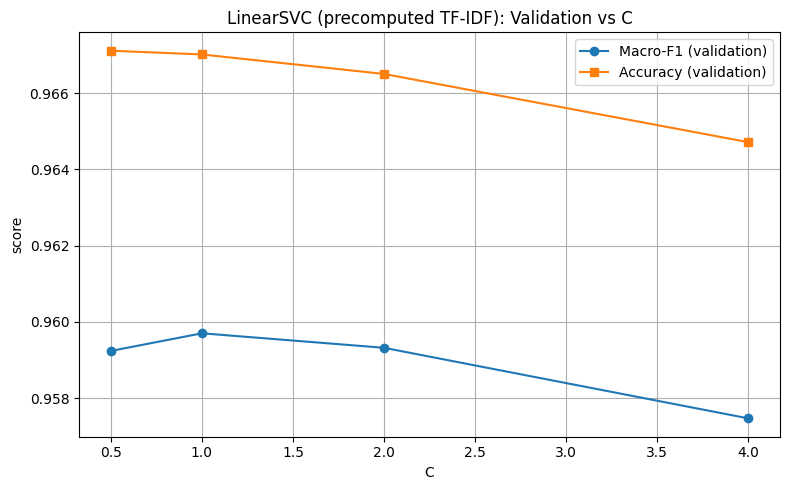


=== SVM — Final Test Report ===
              precision    recall  f1-score   support

           0     0.9754    0.9708    0.9731     15541
           1     0.9779    0.9727    0.9753     17887
           2     0.9476    0.9429    0.9452      3430
           3     0.9586    0.9657    0.9622      7153
           4     0.9580    0.9708    0.9644      5479
           5     0.9243    0.9638    0.9436      1380

    accuracy                         0.9687     50870
   macro avg     0.9570    0.9644    0.9606     50870
weighted avg     0.9688    0.9687    0.9687     50870



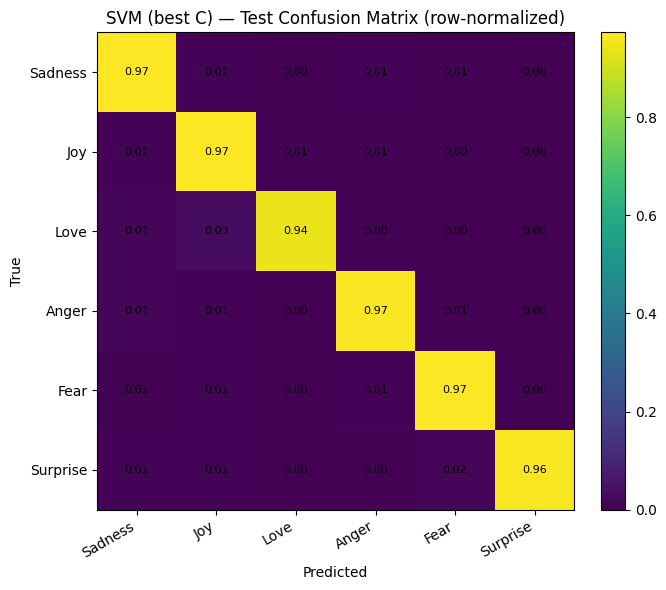

Saved: /kaggle/working/svm_best_model.pkl


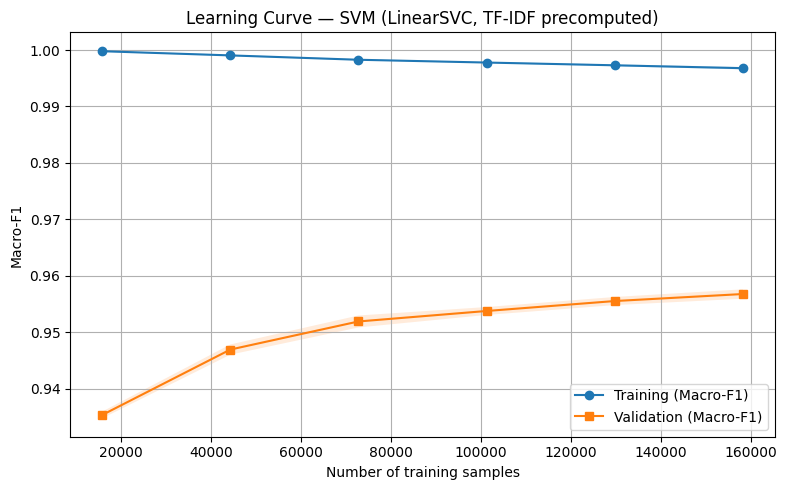

In [2]:
# === SVM (LinearSVC) on precomputed TF-IDF: tune C, plot, retrain, test, save, learning curve ===
import numpy as np
import joblib
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import vstack

from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import learning_curve

# --- Load precomputed features/labels ---
X_train = sparse.load_npz("/kaggle/input/data-preprocessing-assignment/X_train_tfidf.npz")
X_val   = sparse.load_npz("/kaggle/input/data-preprocessing-assignment/X_val_tfidf.npz")
X_test  = sparse.load_npz("/kaggle/input/data-preprocessing-assignment/X_test_tfidf.npz")
y_train = np.load("/kaggle/input/data-preprocessing-assignment/y_train.npy")
y_val   = np.load("/kaggle/input/data-preprocessing-assignment/y_val.npy")
y_test  = np.load("/kaggle/input/data-preprocessing-assignment/y_test.npy")

print("Samples:",
      "\n  train:", len(y_train),
      "\n  val  :", len(y_val),
      "\n  test :", len(y_test))

# --- Hyperparameter sweep on validation ---
C_GRID = [0.5, 1.0, 2.0, 4.0]
records = []  # (C, macroF1, acc)
best_C, best_f1 = None, -1.0

for C in C_GRID:
    clf = LinearSVC(C=C, class_weight="balanced", max_iter=5000)
    clf.fit(X_train, y_train)
    yv = clf.predict(X_val)
    f1m = f1_score(y_val, yv, average="macro")
    acc = accuracy_score(y_val, yv)
    records.append((C, f1m, acc))
    if f1m > best_f1:
        best_f1, best_C = f1m, C

print("\nValidation comparison (C → Macro-F1 / Accuracy):")
for C, f1m, acc in records:
    print(f"  C={C:<3}  macroF1={f1m:.4f}  acc={acc:.4f}")
print(f"\nBest C on validation: {best_C} (macroF1={best_f1:.4f})")

# --- Plot validation sweep ---
records_sorted = sorted(records, key=lambda x: x[0])
cs_plot  = [r[0] for r in records_sorted]
f1_plot  = [r[1] for r in records_sorted]
acc_plot = [r[2] for r in records_sorted]

plt.figure(figsize=(8,5))
plt.plot(cs_plot, f1_plot, marker="o", label="Macro-F1 (validation)")
plt.plot(cs_plot, acc_plot, marker="s", label="Accuracy (validation)")
plt.xlabel("C"); plt.ylabel("score")
plt.title("LinearSVC (precomputed TF-IDF): Validation vs C")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# --- Retrain on Train+Val with best C ---
X_trval = vstack([X_train, X_val])
y_trval = np.concatenate([y_train, y_val])

final_svm = LinearSVC(C=best_C, class_weight="balanced", max_iter=5000)
final_svm.fit(X_trval, y_trval)

# --- Final test evaluation ---
yt = final_svm.predict(X_test)
print("\n=== SVM — Final Test Report ===")
print(classification_report(y_test, yt, digits=4))

# Confusion matrix (row-normalized)
LABEL_MAP = {0:"Sadness",1:"Joy",2:"Love",3:"Anger",4:"Fear",5:"Surprise"}
cm = confusion_matrix(y_test, yt, labels=[0,1,2,3,4,5])
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(7.5,6))
im = ax.imshow(cm_norm, interpolation='nearest')
ax.set_title("SVM (best C) — Test Confusion Matrix (row-normalized)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticks(range(6)); ax.set_yticks(range(6))
ax.set_xticklabels([LABEL_MAP[i] for i in range(6)], rotation=30, ha="right")
ax.set_yticklabels([LABEL_MAP[i] for i in range(6)])
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, f"{cm_norm[i,j]:.2f}", ha="center", va="center", fontsize=8)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

# --- Save the trained classifier (model-only) ---
joblib.dump(final_svm, "/kaggle/working/svm_best_model.pkl")
print("Saved: /kaggle/working/svm_best_model.pkl")

# =======================
# === Learning Curve  ===
# =======================
# Compute learning curves directly on the precomputed training matrix.
lc_clf = LinearSVC(C=best_C, class_weight="balanced", max_iter=5000)

train_sizes = np.linspace(0.1, 1.0, 6)  # 10%, 28%, ..., 100%
train_sizes_abs, train_scores, val_scores = learning_curve(
    estimator=lc_clf,
    X=X_train,          # only TRAIN split (no leakage)
    y=y_train,
    cv=3,               # 3-fold CV within the train split
    scoring="f1_macro",
    train_sizes=train_sizes,
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes_abs, train_mean, marker="o", label="Training (Macro-F1)")
plt.fill_between(train_sizes_abs, train_mean-train_std, train_mean+train_std, alpha=0.15)
plt.plot(train_sizes_abs, val_mean, marker="s", label="Validation (Macro-F1)")
plt.fill_between(train_sizes_abs, val_mean-val_std, val_mean+val_std, alpha=0.15)
plt.xlabel("Number of training samples")
plt.ylabel("Macro-F1")
plt.title("Learning Curve — SVM (LinearSVC, TF-IDF precomputed)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()